# fastbook 09 (DT, RF & DL) with California Housing Prices

In [1]:
from fastai.imports import *
from fastai.tabular.all import *
from kaggle import api

In [14]:
data = 'camnugent/california-housing-prices'
api.dataset_list_cli(search=data)

ref                                  title                       size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------  -------------------------  -----  -------------------  -------------  ---------  ---------------  
camnugent/california-housing-prices  California Housing Prices  400KB  2017-11-24 03:14:59          70916        741  0.85294116       


In [4]:
path = Path(data.split('/')[1])
api.dataset_download_files(data, path)
path.ls()

(#1) [Path('california-housing-prices/california-housing-prices.zip')]

In [5]:
import zipfile
zipfile.ZipFile(path.ls()[0]).extractall(path)
path.ls()

(#2) [Path('california-housing-prices/california-housing-prices.zip'),Path('california-housing-prices/housing.csv')]

In [6]:
df = pd.read_csv(path/'housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [8]:
cat = ['ocean_proximity']
cont = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
procs = [Categorify, FillMissing, Normalize]
to = TabularPandas(df, procs, cat, cont, 'median_house_value', RegressionBlock(),  RandomSplitter()(df), reduce_memory=False).dataloaders(path='.')

xs,y = to.train.xs,to.train.y
val_xs,val_y = to.valid.xs,to.valid.y

## DT

In [9]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz

m = DecisionTreeRegressor(max_leaf_nodes=30).fit(xs, y)
preds = m.predict(val_xs)
abs(val_y - preds).mean()

48875.64730479602

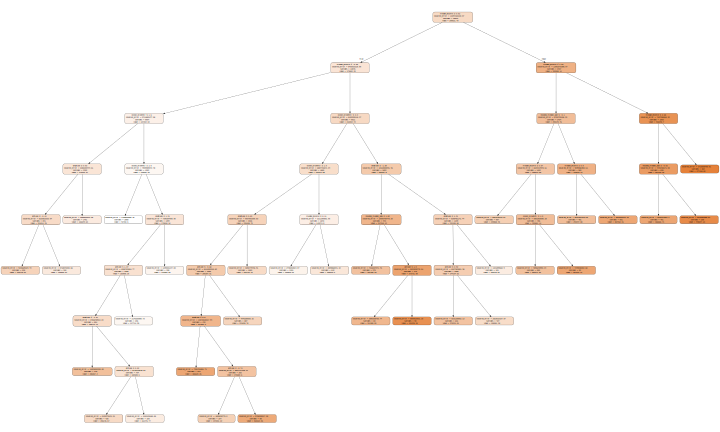

In [10]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

draw_tree(m, xs, size=10)

## RF

In [11]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(100, min_samples_leaf=5).fit(xs, y)
preds = rf.predict(val_xs)
print('MAE:', abs(val_y - preds).mean())

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
rf_feat_importance(m, xs)

MAE: 32801.87284654991


,cols,imp
9,median_income,0.693280
0,ocean_proximity,0.155839
2,longitude,0.066292
3,latitude,0.056939
4,housing_median_age,0.027651
1,total_bedrooms_na,0.000000
5,total_rooms,0.000000
6,total_bedrooms,0.000000
7,population,0.000000
8,households,0.000000


## DNN

SuggestedLRs(slide=6.309573450380412e-07, valley=0.25118863582611084)

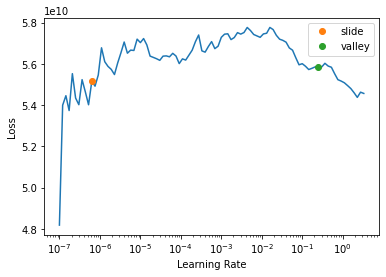

In [12]:
learn = tabular_learner(to, metrics=L1LossFlat(), layers=[10,10])
learn.lr_find(suggest_funcs=(slide, valley))

epoch,train_loss,valid_loss,None,time
0,53097254912.000000,50091327488.000000,197038.031250,00:02
1,40575660032.000000,32661778432.000000,158515.828125,00:02
2,29214582784.000000,29792092160.000000,154793.359375,00:02
3,21337401344.000000,21841612800.000000,131071.546875,00:02
4,15031523328.000000,14989235200.000000,106777.507812,00:02
5,10078326784.000000,8497321984.000000,73958.375000,00:02
6,7243347456.000000,5410910208.000000,54345.613281,00:02
7,5793301504.000000,7081321984.000000,61764.933594,00:02
8,4661496320.000000,4952012288.000000,49785.355469,00:03
9,4318746624.000000,4231413504.000000,45573.707031,00:02


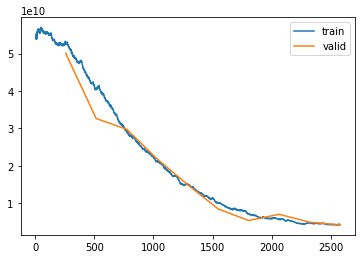

In [13]:
learn.fit(10, lr=0.1)
learn.recorder.plot_loss()